# A Simple Autoencoder in TensorFlow

We'll start off by building a simple autoencoder to compress the MNIST dataset. With autoencoders, we pass input data through an encoder that makes a compressed representation of the input. Then, this representation is passed through a decoder to reconstruct the input data. Generally the encoder and decoder will be built with neural networks, then trained on example data.

![Autoencoder](assets/autoencoder_1.png)

In this notebook, we'll be build a simple network architecture for the encoder and decoder. Let's get started by importing our libraries and getting the dataset.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Below I'm plotting an example image from the MNIST dataset. These are 28x28 grayscale images of handwritten digits.

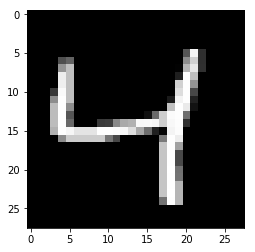

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

We'll train an autoencoder with these images by flattening them into 784 length vectors. The images from this dataset are already normalized such that the values are between 0 and 1. 

In [4]:
img[400:410]

array([ 0.        ,  0.18431373,  0.19215688,  0.45490199,  0.56470591,
        0.58823532,  0.9450981 ,  0.95294124,  0.91764712,  0.7019608 ], dtype=float32)

Let's start by building basically the simplest autoencoder with a **single ReLU hidden layer**. This layer will be used as the compressed representation. Then, the encoder is the input layer and the hidden layer. The decoder is the hidden layer and the output layer. Since the images are normalized between 0 and 1, we need to use a **sigmoid activation on the output layer** to get values matching the input.

![Autoencoder architecture](assets/simple_autoencoder.png)


In [5]:
# Size of the encoding layer (the hidden layer)
encoding_dim = 32

image_size = mnist.train.images.shape[1]
print(image_size)

784


In [13]:
inputs_ = tf.placeholder(tf.float32, (None, image_size), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, image_size), name='targets')

# Hidden layer
# The image is reduced to an tensor of length 32
encoded = tf.layers.dense(inputs_, encoding_dim, activation=tf.nn.relu)

# Output layer logits
# The output layer expands the compressed tensor back to its original size,
# these values are not normalized.
logits = tf.layers.dense(encoded, image_size, activation=None)

# Sigmoid turns each of the 758 logits into numbers in the [0, 1] range, 
# and this tensor is the output image
decoded = tf.nn.sigmoid(logits, name='output')

# this function applies the sigmoid to the logits, obtaining a reproduction of the image,
# (yes, this is redundant because we just did it above, but it is ok in this small example) 
# and then computes the distance (cross entropy) between the the reproduction and the target (the input image)
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(0.001).minimize(cost)

## Training

In [7]:
# Create the session
sess = tf.Session()

Calling `mnist.train.next_batch(batch_size)` will return a tuple of `(images, labels)`. We're not concerned with the labels here, we just need the images. Otherwise this is pretty straightfoward training with TensorFlow. We initialize the variables with `sess.run(tf.global_variables_initializer())`. Then, run the optimizer and get the loss with `batch_cost, _ = sess.run([cost, opt], feed_dict=feed)`.

In [8]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        feed = {inputs_: batch[0], targets_: batch[0]}
        batch_cost, _ = sess.run([cost, opt], feed_dict=feed)

    print("Epoch: {}/{}...".format(e+1, epochs),
          "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.1878
Epoch: 2/20... Training loss: 0.1565
Epoch: 3/20... Training loss: 0.1346
Epoch: 4/20... Training loss: 0.1247
Epoch: 5/20... Training loss: 0.1087
Epoch: 6/20... Training loss: 0.1028
Epoch: 7/20... Training loss: 0.0999
Epoch: 8/20... Training loss: 0.0965
Epoch: 9/20... Training loss: 0.0969
Epoch: 10/20... Training loss: 0.0924
Epoch: 11/20... Training loss: 0.0933
Epoch: 12/20... Training loss: 0.0972
Epoch: 13/20... Training loss: 0.0919
Epoch: 14/20... Training loss: 0.0920
Epoch: 15/20... Training loss: 0.0904
Epoch: 16/20... Training loss: 0.0958
Epoch: 17/20... Training loss: 0.0963
Epoch: 18/20... Training loss: 0.0944
Epoch: 19/20... Training loss: 0.0942
Epoch: 20/20... Training loss: 0.0954


## Checking out the results

Below I've plotted some of the test images along with their reconstructions. For the most part these look pretty good except for some blurriness in some parts.

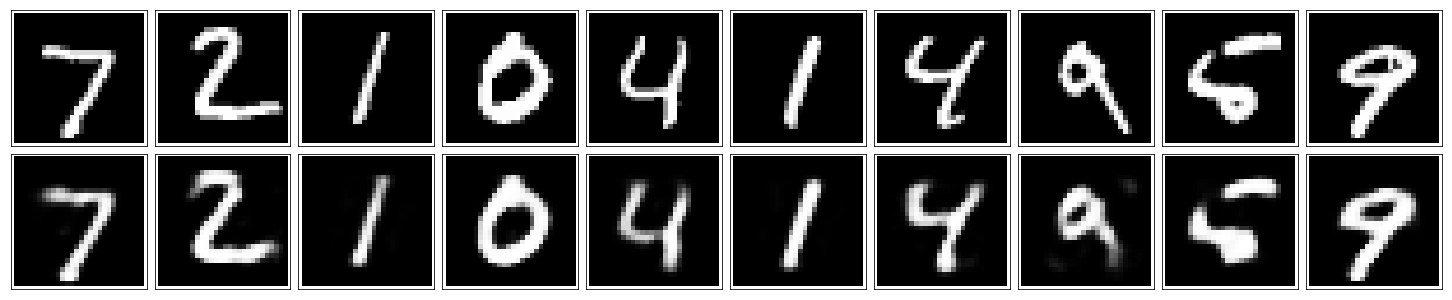

In [9]:
in_imgs = mnist.test.images[:10]
reconstructed, compressed = sess.run([decoded, encoded], feed_dict={inputs_: in_imgs})

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))

# for each of the 2 rows
for images, row in zip([in_imgs, reconstructed, compressed], axes):
    
    # for each of the 10 digits
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

And below are the compressed representations of the first 10 inputs, if you look closely you can appreciate that there are common patterns in the 3rd and 6th inputs, because they both correspond to the same digit (1).

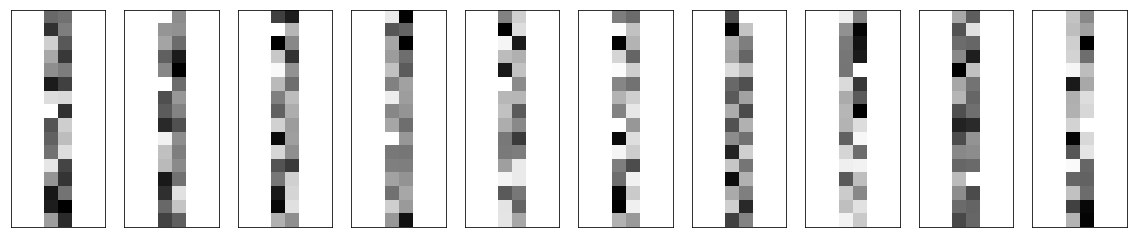

In [10]:
fig1, axes1 = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(20, 4))


# for each of the 10 digits
for img, ax in zip(compressed, axes1):
    ax.imshow(img.reshape((16, 2)), cmap='Greys_r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

In [11]:
sess.close()